In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np
from load_5hot import load
from onehot_tostring import convert_to_nucs, show_noise
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D, Add, Reshape
from keras.layers import AveragePooling2D, UpSampling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.core import Lambda
from keras.models import Model
import matplotlib.pyplot as plt
import datetime
from keras.activations import softmax

K.set_image_data_format('channels_last')
print('Done')

Done


In [8]:
[X_train,Y_train,X_test,Y_test,X_val,Y_val] = load("blast_tab_1hit.out")

Loading Data...
101886 sequences were uploaded

Maximum sequence length in is 308
Maximum sequence length out is 308

Converting to one-hot...
Done
Converting to one-hot...
Done
Converting to one-hot...
Done


In [9]:
m = X_train.shape[0]
print("There are " + str(m) + " training examples")
print("There are " + str(X_val.shape[0]) + " validation examples")
print("There are " + str(X_test.shape[0]) + " testing examples")
print("There are " + str(X_train.shape[1]) + " classes: A, C, G, T, -")
max_length = max(X_train.shape[2],X_test.shape[2])
print("The longest sequence is " + str(max_length) + " nucleotides long")
print("X_train shape is:")
print(X_train.shape)

There are 77510 training examples
There are 12269 validation examples
There are 12107 testing examples
There are 5 classes: A, C, G, T, -
The longest sequence is 308 nucleotides long
X_train shape is:
(77510, 5, 308, 1)


In [17]:
# Visualize data sets to ensure they appear as anticipated
def display_example_sequences(X,Y,n):
    for sample in range(n):
        samp_n_X = convert_to_nucs(X[sample,:,:,0])
        samp_n_Y = convert_to_nucs(Y[sample,:,:,0])
        print(samp_n_X + ', ' + samp_n_Y + '\n')

    print('')
    
n_examples = 3
print('\nTraining Examples:\n')
display_example_sequences(X_train,Y_train,n_examples)
print('\nValidation Examples:\n')
display_example_sequences(X_val,Y_val,n_examples)
print('\nTesting Examples:\n')
display_example_sequences(X_test,Y_test,n_examples)


Training Examples:

ACGGAGGGTGCGAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGCTTGGTAAGTCAGGGGTGAAAGCCCGCGGCTCAACCGCGGAATTGCCTTTGATACTGC-CGAGCTAGAGTCCGGGAGAGGGTAGTGGAATTCCAGGTGTAGGAGTGAAATCCGTAGAGATCTGGAGGAACATCAGTGGCGAAGGCGACTACCTGGACCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------, ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAAGCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGGCCACCTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------

ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCAGGCGGTGGGCTGCGTCGGCGCTGAAAGCGCCCCGCTTAACGGGGCGAGGCGCGCCGATACGAGTCCACTCGAGGCAAGCAGAGGGTGGCGGAATTCCGGGTGGAGTGGTGAAATGCGTAGAGATCCGGAGGAACGCCGGTGGGGAAGCCGGCCACCTGGGCTTGACCTGACGCTGCGGCGCGACAGCGTGGGGAGCAAACCG---------------------------------------------------------, ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCA

In [18]:
print('Permuting training samples...')
np.random.seed(0)
rand_perm = np.random.rand(m).argsort()
np.take(X_train,rand_perm,axis=0,out=X_train)
print("finished X")
np.take(Y_train,rand_perm,axis=0,out=Y_train)
print("finished Y")

Permuting training samples...
finished X
finished Y


In [20]:
ngf = 16
input_nc = 1
output_nc = 1
n_blocks_gen = 9

def softMaxAxis1(x):
    return softmax(x,axis=1)

# started from: https://blog.sicara.com/keras-generative-adversarial-networks-image-deblurring-45e3ab6977b5
def Model_1(input_shape):
    """Build generator architecture."""
    # Current version : ResNet block
    X_input = Input(input_shape)
    
    # X = ZeroPadding2D((0, 3))(X_input) # allows 'valid' in conv0 to keep length and collapse one-hot

    X = Conv2D(128, (4, 7), strides = (1, 1), padding = 'same', name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
#     X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv1')(X)
#     X = BatchNormalization(axis = 3, name = 'bn1')(X)
#     X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3, name = 'dropout')(X)
   
    X = Conv2D(32, (1, 7), strides = (1, 1), padding = 'same', name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Dense(1, activation = softMaxAxis1)(X)
    
    model = Model(inputs=X_input, outputs=X, name='Model_2')
    return model

In [21]:
myModel = Model_1((5,max_length,1))
print(myModel.summary())
print('Done!')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 308, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 308, 128)       3712      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 308, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 5, 308, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 308, 64)        57408     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 5, 308, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 5, 308, 64)        0         
__________

In [22]:
myModel.compile(optimizer="Adam", loss="mean_squared_error", metrics = ["accuracy"])
print('Done!')

Done!


In [24]:
# Understand baseline accuracy of if model output its own input
diffs = np.absolute(X_train-Y_train);
err = np.sum(diffs)/np.ma.size(X_train);
print("Baseline accuracy of Train if predicting output = input is " + str(1-err))

diffs = np.absolute(X_val-Y_val);
err = np.sum(diffs)/np.ma.size(X_val);
print("Baseline accuracy of Val if predicting output = input is " + str(1-err))

diffs = np.absolute(X_test-Y_test);
err = np.sum(diffs)/np.ma.size(X_test);
print("Baseline accuracy of Test if predicting output = input is " + str(1-err))

Baseline accuracy of Train if predicting output = input is 0.994588750173836
Baseline accuracy of Val if predicting output = input is 0.999137833394904
Baseline accuracy of Test if predicting output = input is 0.9990534616123119


In [ ]:
history = myModel.fit(x = X_train, y = Y_train, epochs = 20, validation_data = (X_val, Y_val), batch_size = 30, verbose = 1)

loss_and_acc = myModel.evaluate(X_test, Y_test)
print(loss_and_acc)

currtime = datetime.datetime.now()
fname = "./convWeights/" + currtime.strftime("%m%d-%H%M") + "_5hot.hdf5"
print(fname)
myModel.save_weights(fname)

Train on 77510 samples, validate on 12269 samples
Epoch 1/20
 5910/77510 [=>............................] - ETA: 41:44 - loss: 0.0280 - acc: 0.9921

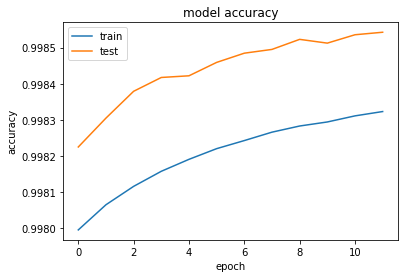

In [67]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
preds = myModel.predict(x = X_test)

In [100]:
# Show whole sequence
for n in range(100):
    print("Sample number " + str(n+1))
    samp_n_pred = preds[n,:,:,0]
    samp_n_in = X_test[n,:,:,0]
    samp_n_true = Y_test[n,:,:,0]

    samp_n_pred = convert_to_nucs(samp_n_pred)
    samp_n_true = convert_to_nucs(samp_n_true)
    samp_n_in = convert_to_nucs(samp_n_in)
    noisy = show_noise(samp_n_pred, samp_n_true, samp_n_in)

    print('Predicted:')
    print('Denoised:')
    print('Noisy:')
    print('Noise locations:\n')

    stt = 0
    stp = 100
    while(stp < len(noisy)):
        print(samp_n_pred[stt:stp])
        print(samp_n_true[stt:stp])
        print(samp_n_in[stt:stp])
        print(noisy[stt:stp])
        print('')
        stt = stp
        stp = stt+100



Sample number 1
Predicted:
Denoised:
Noisy:
Noise locations:

ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
----------------------------------------------------------------------------------------------------

GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
----------------------------------------------------------------------------------------------------

CCACCTGGTCCACCCGTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACCG-------------------------------------------------
CCACCTGGTCCACCCGTGACGCTGAGG

Predicted:
Denoised:
Noisy:
Noise locations:

ACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTCGGAAAGAAAGATGTGAAATCCCAGGGCTTAACCTTGGAACTGC
ACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTCGGAAAGAAAGATGTGAAATCCCAGGGCTTAACCTTGGAACTGC
ACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGT-AAGCGTGCGCAGGCGGTTCGGAAAGAAAGATGTGAAATCCCAGGGCTTAACCTTGGAACTGC
-------------------------------------g--------------------------------------------------------------

ATTTTTAACTACCGGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAG
ATTTTTAACTACCGGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAG
ATTTTTAACTACCGGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAG
----------------------------------------------------------------------------------------------------

CCTCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAG-------------------------------------------------
CCTCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGA

In [95]:
myModel.load_weights("./convWeights/0531-2012_5hot.hdf5")